In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

2024-08-16 12:21:50.212672: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 12:21:50.242899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 12:21:50.242927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 12:21:50.244069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 12:21:50.249592: I tensorflow/core/platform/cpu_feature_gua

In [2]:
ds = xr.open_dataset('../rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
df = ds.to_dataframe()
df_orig = df.copy()

In [3]:
list(df.keys())

['Wind Direction (TAO)',
 'WDIR_QC',
 'WDIR_DM',
 'Wind Speed (TAO)',
 'WSPD_QC',
 'WSPD_DM',
 'Zonal Wind Speed (TAO)',
 'Meridional Wind Speed (TAO)',
 'Sea Surface Temperature (TAO)',
 'SST_QC',
 'SST_DM',
 'Relative Humidity (TAO)',
 'RELH_QC',
 'RELH_DM',
 'Air Temperature (TAO)',
 'AIRT_QC',
 'AIRT_DM',
 'Neutral Wind Speed at 10m (TAO)',
 'Wind Speed at 10m (TAO)',
 'mean WSPD 20min',
 'std. dev. WSPD 20min',
 'mean WSPD_10N 20min',
 'std. dev. WSPD_10N 20min',
 'mean Ux_10N 20min',
 'std. dev. Ux_10N 20min',
 'mean Vy_10N 20min',
 'std. dev. Vy_10N 20min',
 'mean WDIR 20min',
 'std. dev. WDIR 20min',
 'mean WSPD 30min',
 'std. dev. WSPD 30min',
 'mean WSPD_10N 30min',
 'std. dev. WSPD_10N 30min',
 'mean Ux_10N 30min',
 'std. dev. Ux_10N 30min',
 'mean Vy_10N 30min',
 'std. dev. Vy_10N 30min',
 'mean WDIR 30min',
 'std. dev. WDIR 30min',
 'mean WSPD 40min',
 'std. dev. WSPD 40min',
 'mean WSPD_10N 40min',
 'std. dev. WSPD_10N 40min',
 'mean Ux_10N 40min',
 'std. dev. Ux_10N 40mi

In [4]:
df['cos(Direction Difference (QuikSCAT - TAO))'] = np.cos(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))
df['sin(Direction Difference (QuikSCAT - TAO))'] = np.sin(np.deg2rad(df['Direction Difference (QuikSCAT - TAO)']))


for timeWindow in range(20,130,10):
    df[f'cos(Direction Difference (QuikSCAT - TAO {timeWindow} min mean))'] = np.cos(np.deg2rad(df[f'Direction Difference (QuikSCAT - TAO {timeWindow} min mean)']))
    df[f'sin(Direction Difference (QuikSCAT - TAO {timeWindow} min mean))'] = np.sin(np.deg2rad(df[f'Direction Difference (QuikSCAT - TAO {timeWindow} min mean)']))


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

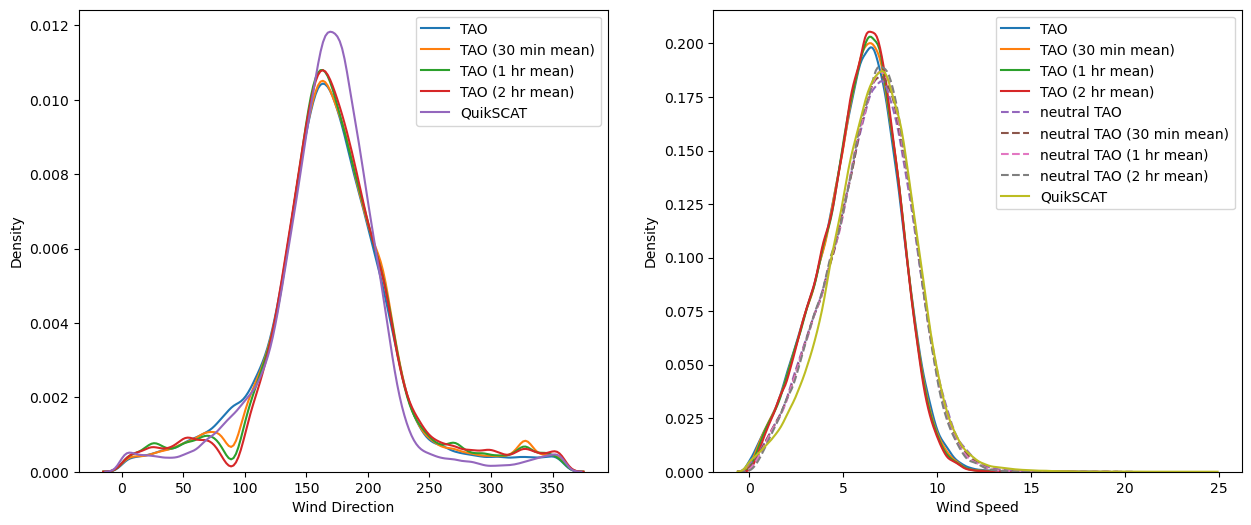

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

ax = axes[0]
sns.kdeplot(df['Wind Direction (TAO)'], ax = ax, label = 'TAO')
sns.kdeplot(df['mean WDIR 30min'], ax = ax, label = 'TAO (30 min mean)')
sns.kdeplot(df['mean WDIR 60min'], ax = ax, label = 'TAO (1 hr mean)')
sns.kdeplot(df['mean WDIR 120min'], ax = ax, label = 'TAO (2 hr mean)')
sns.kdeplot(df['Wind Direction (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('Wind Direction')
ax.legend()

ax = axes[1]
sns.kdeplot(df['Wind Speed (TAO)'], ax = ax, label = 'TAO')
sns.kdeplot(df['mean WSPD 30min'], ax = ax, label = 'TAO (30 min mean)')
sns.kdeplot(df['mean WSPD 60min'], ax = ax, label = 'TAO (1 hr mean)')
sns.kdeplot(df['mean WSPD 120min'], ax = ax, label = 'TAO (2 hr mean)')

sns.kdeplot(df['Neutral Wind Speed at 10m (TAO)'], linestyle="--", ax = ax, label = 'neutral TAO')
sns.kdeplot(df['mean WSPD_10N 30min'], linestyle="--", ax = ax, label = 'neutral TAO (30 min mean)')
sns.kdeplot(df['mean WSPD_10N 60min'], linestyle="--", ax = ax, label = 'neutral TAO (1 hr mean)')
sns.kdeplot(df['mean WSPD_10N 120min'], linestyle="--", ax = ax, label = 'neutral TAO (2 hr mean)')

sns.kdeplot(df['Wind Speed (QuikSCAT)'], ax = ax, label = 'QuikSCAT')
ax.set_xlabel('Wind Speed')
ax.legend()

0.866015886201487

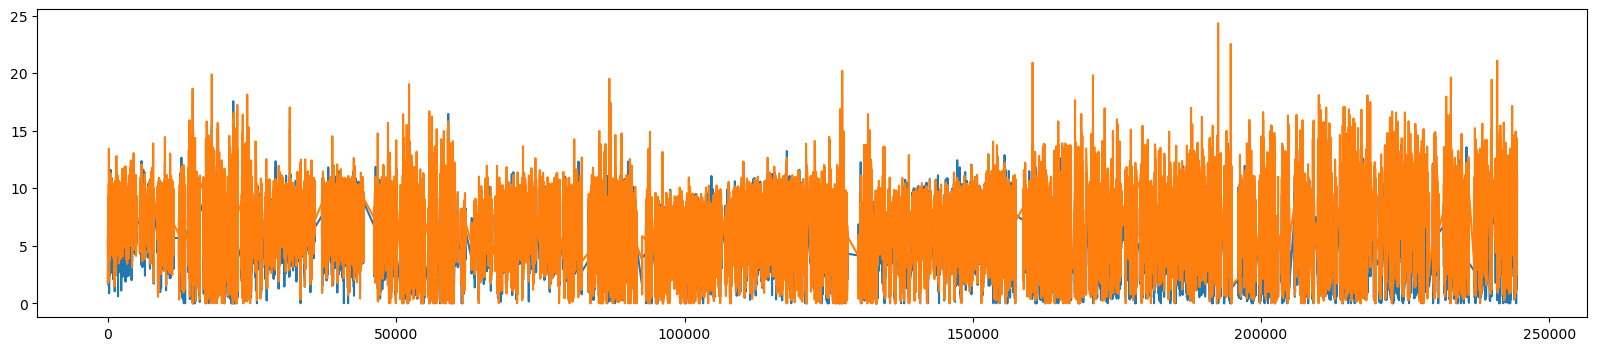

In [6]:
plt.figure(figsize=(20,4))
plt.plot(df['Wind Speed (TAO)'])
plt.plot(df['Wind Speed (QuikSCAT)'])
np.corrcoef(df['Wind Speed (TAO)'], df['Wind Speed (QuikSCAT)'])[0,1]

0.6688673461710766

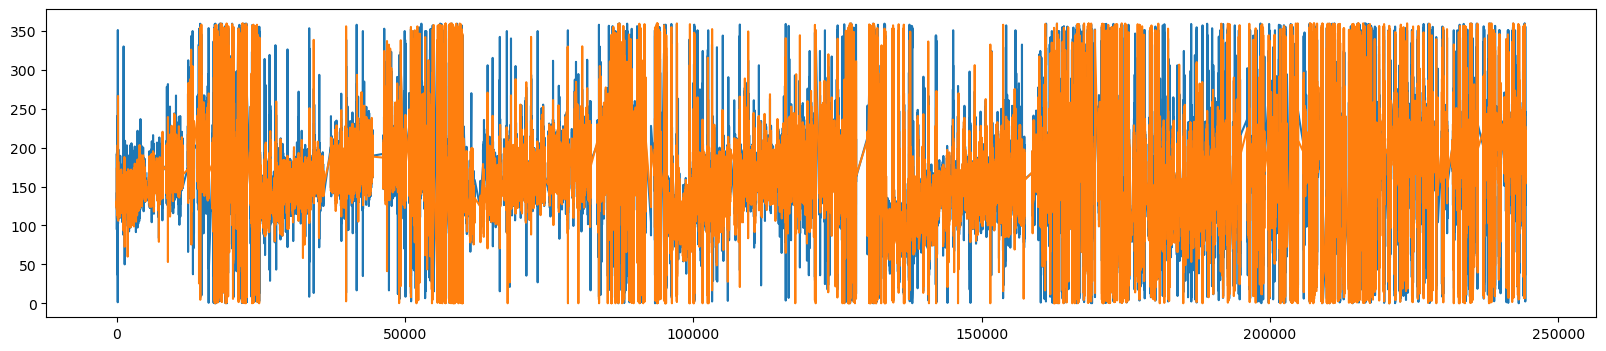

In [7]:
plt.figure(figsize=(20,4))
plt.plot(df['Wind Direction (TAO)'])
plt.plot(df['Wind Direction (QuikSCAT)'])
np.corrcoef(df['Wind Direction (TAO)'], df['Wind Direction (QuikSCAT)'])[0,1]

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='Zonal Neutral Wind Speed (TAO)', ylabel='Meridional Neutral Wind Speed (TAO)'>

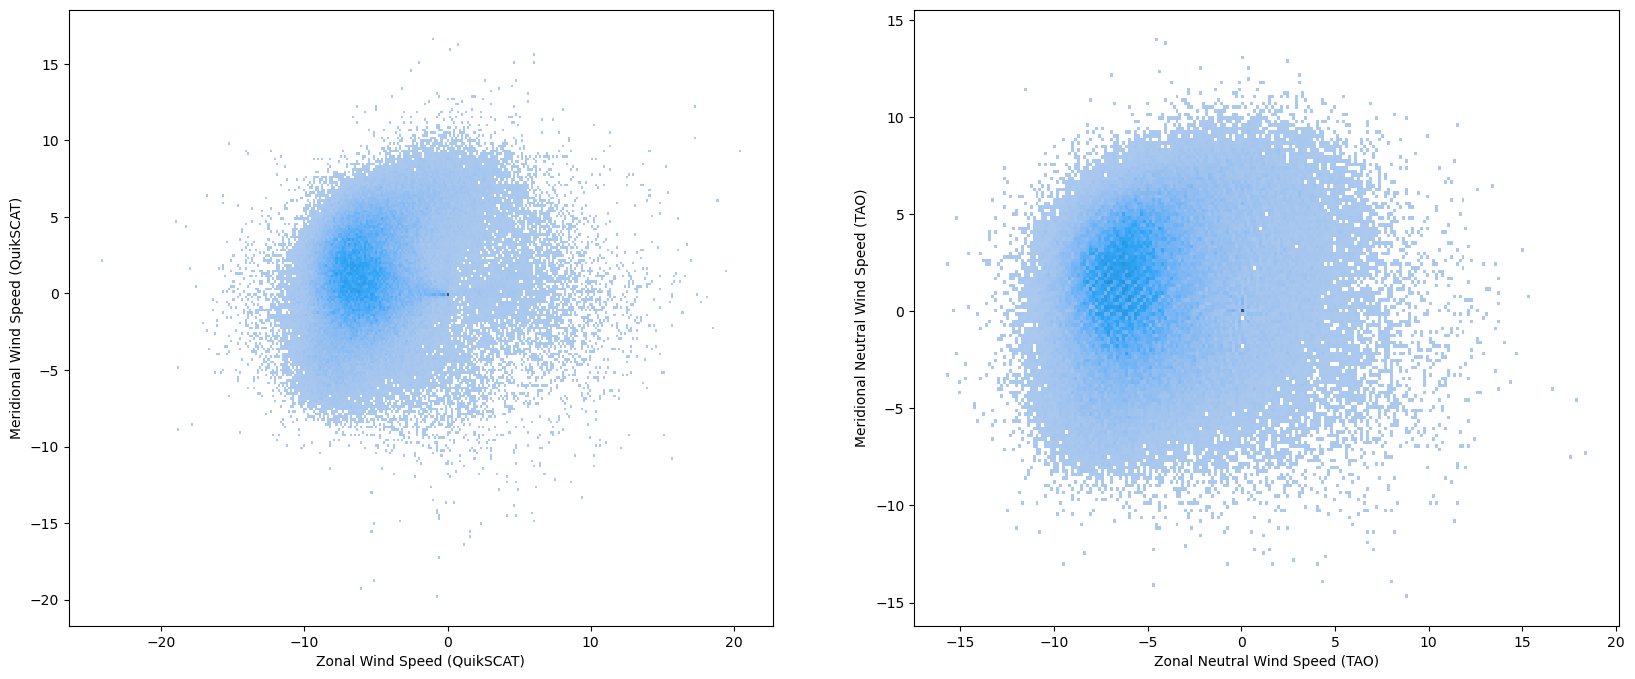

In [8]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,8))

ax = axes[0]
xlabel = 'Zonal Wind Speed (QuikSCAT)'
ylabel = 'Meridional Wind Speed (QuikSCAT)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


ax = axes[1]
xlabel = 'Zonal Neutral Wind Speed (TAO)'
ylabel = 'Meridional Neutral Wind Speed (TAO)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='Meridional Neutral Wind Speed (TAO)', ylabel='Meridional Wind Speed (QuikSCAT)'>

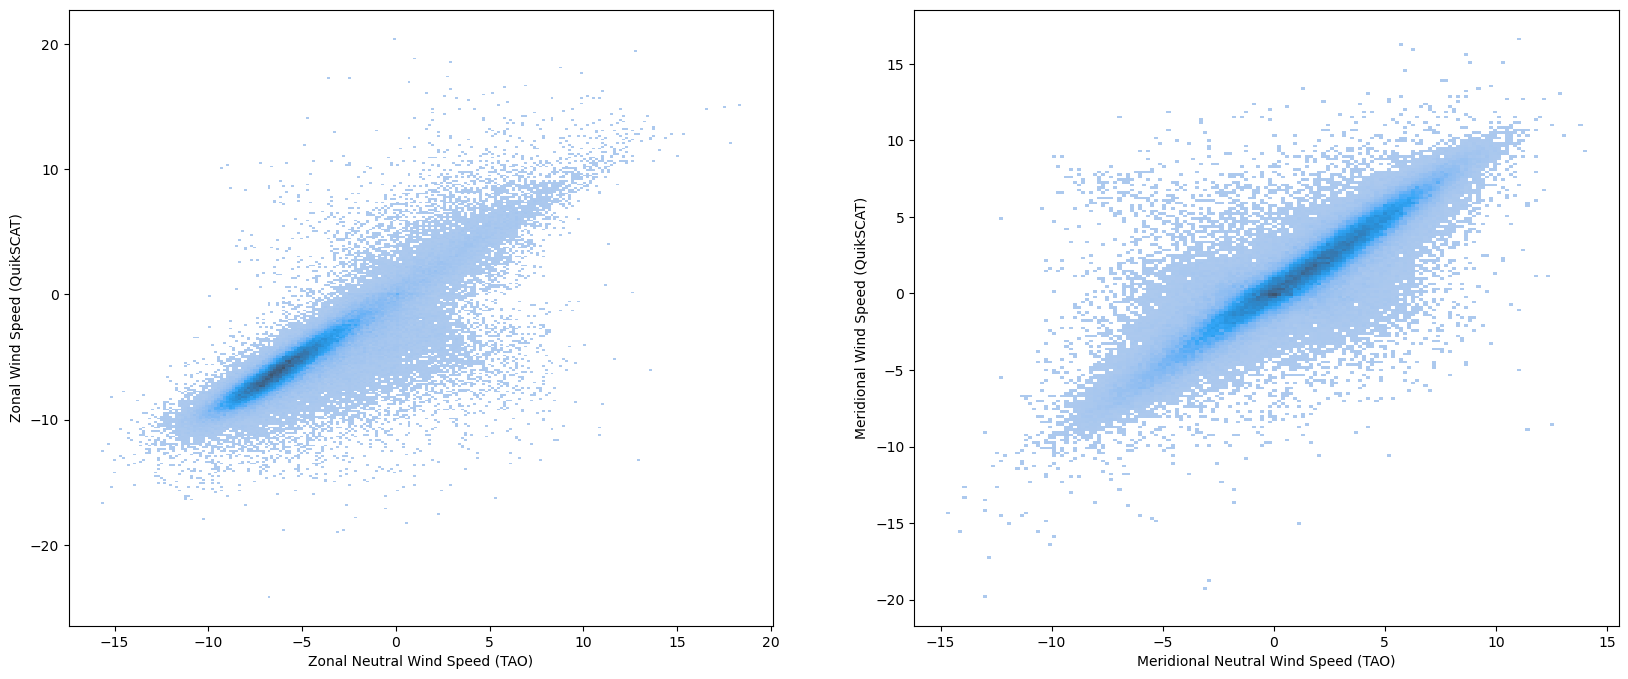

In [9]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,8))

ax = axes[0]
xlabel = 'Zonal Neutral Wind Speed (TAO)'
ylabel = 'Zonal Wind Speed (QuikSCAT)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


ax = axes[1]
xlabel = 'Meridional Neutral Wind Speed (TAO)'
ylabel = 'Meridional Wind Speed (QuikSCAT)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='Wind Direction (TAO)', ylabel='Wind Direction (QuikSCAT)'>

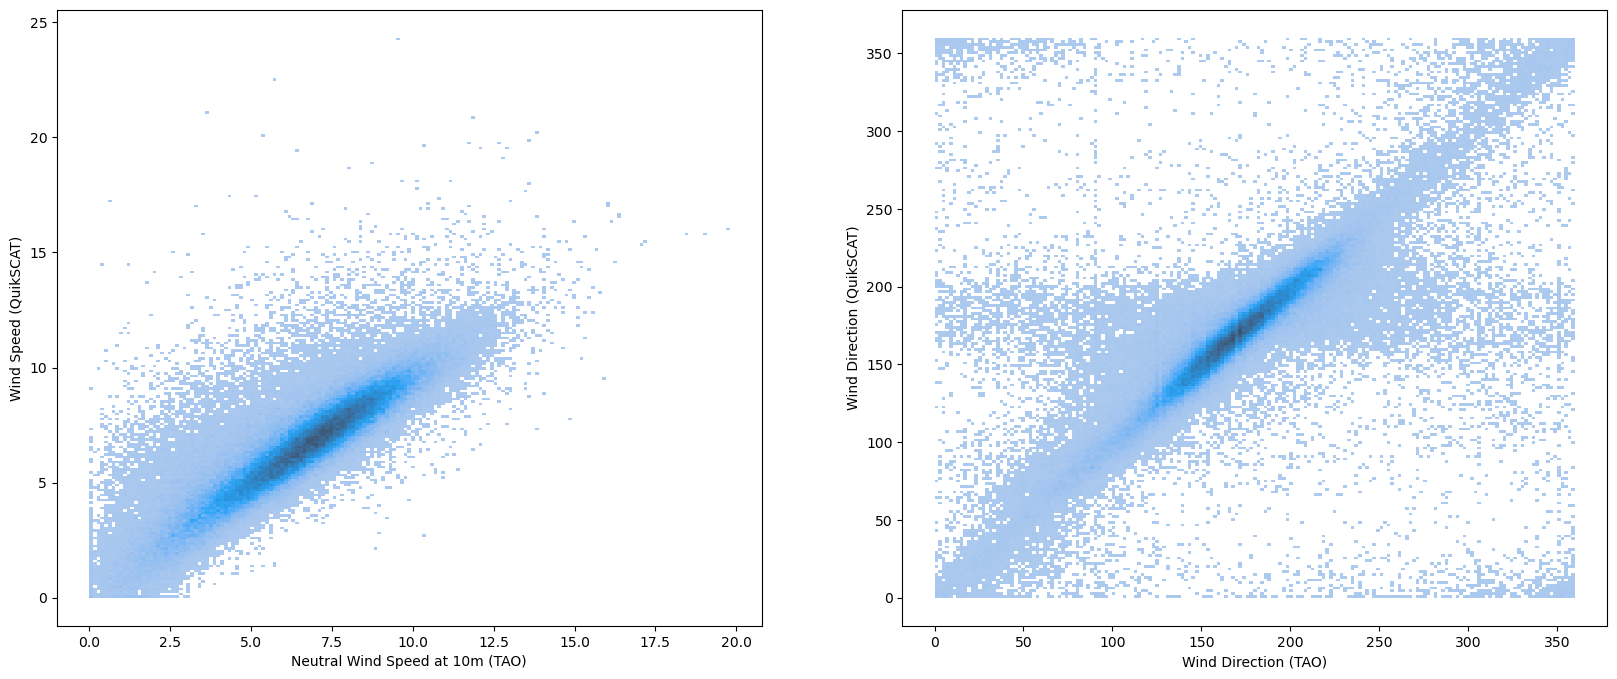

In [10]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,8))

ax = axes[0]
xlabel = 'Neutral Wind Speed at 10m (TAO)'
ylabel = 'Wind Speed (QuikSCAT)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


ax = axes[1]
xlabel = 'Wind Direction (TAO)'
ylabel = 'Wind Direction (QuikSCAT)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='norm Speed Difference (QuikSCAT - TAO)', ylabel='norm Direction Difference (QuikSCAT - TAO)'>

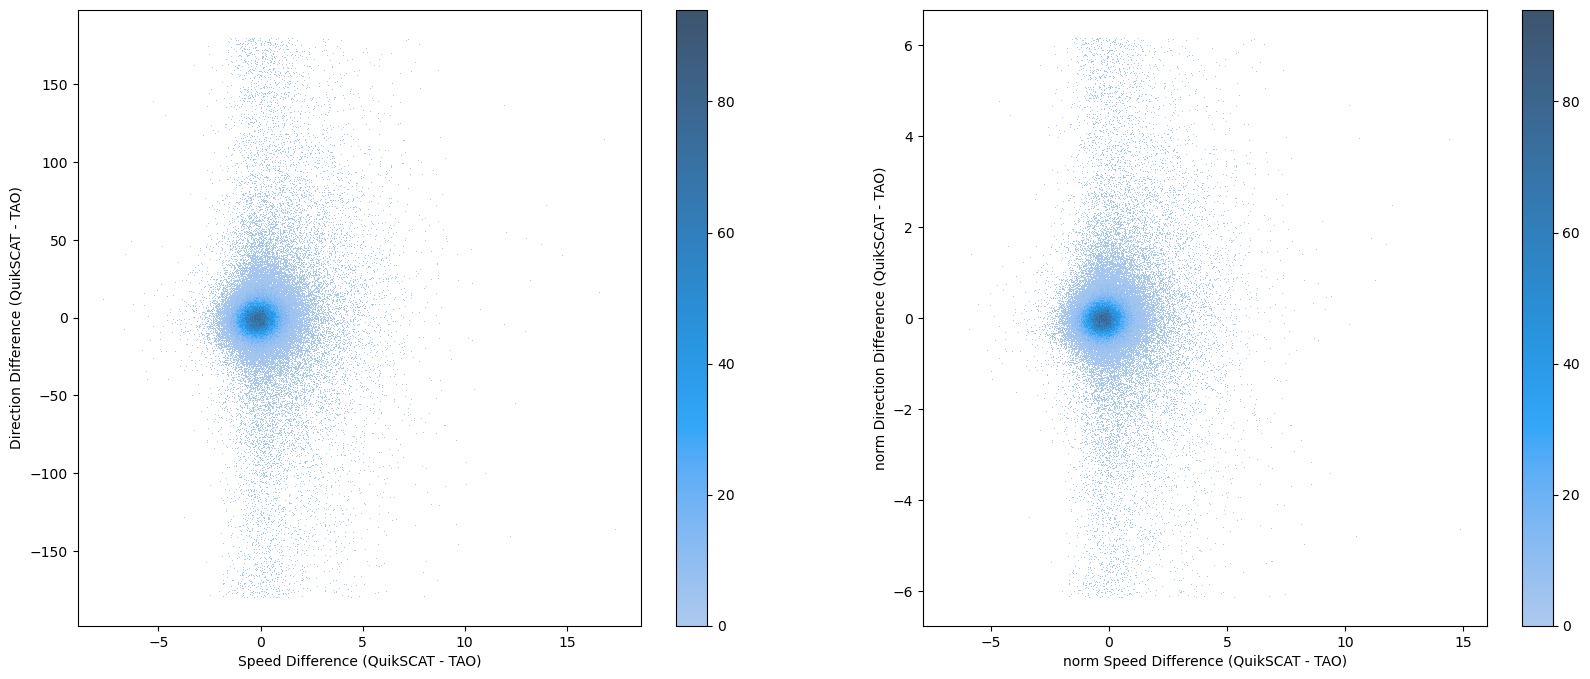

In [11]:
x = df['Speed Difference (QuikSCAT - TAO)']
x = (x - np.mean(x))/np.std(x)

y = df['Direction Difference (QuikSCAT - TAO)']
y = (y - np.mean(y))/np.std(y)

df['norm Speed Difference (QuikSCAT - TAO)'] = x
df['norm Direction Difference (QuikSCAT - TAO)'] = y


fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,8))

ax = axes[0]
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax, cbar = True)


ax = axes[1]
xlabel = 'norm Speed Difference (QuikSCAT - TAO)'
ylabel = 'norm Direction Difference (QuikSCAT - TAO)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax, cbar = True)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

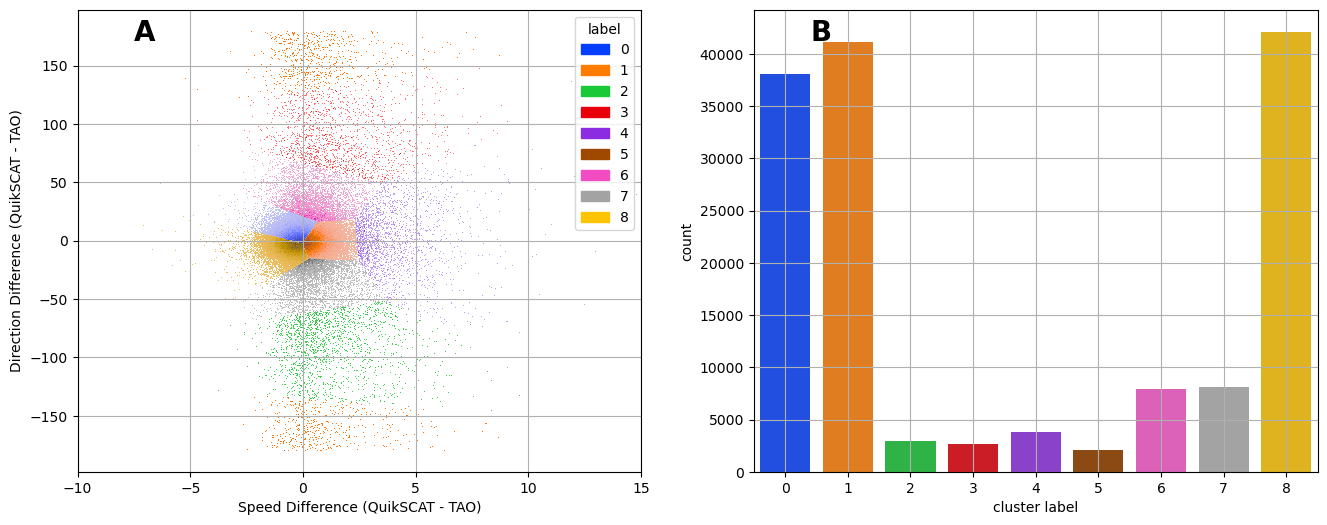

In [13]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label'] = kmeans.labels_

# dbscan = DBSCAN(eps=0.15, min_samples= 500)
# df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=False, cbar = False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

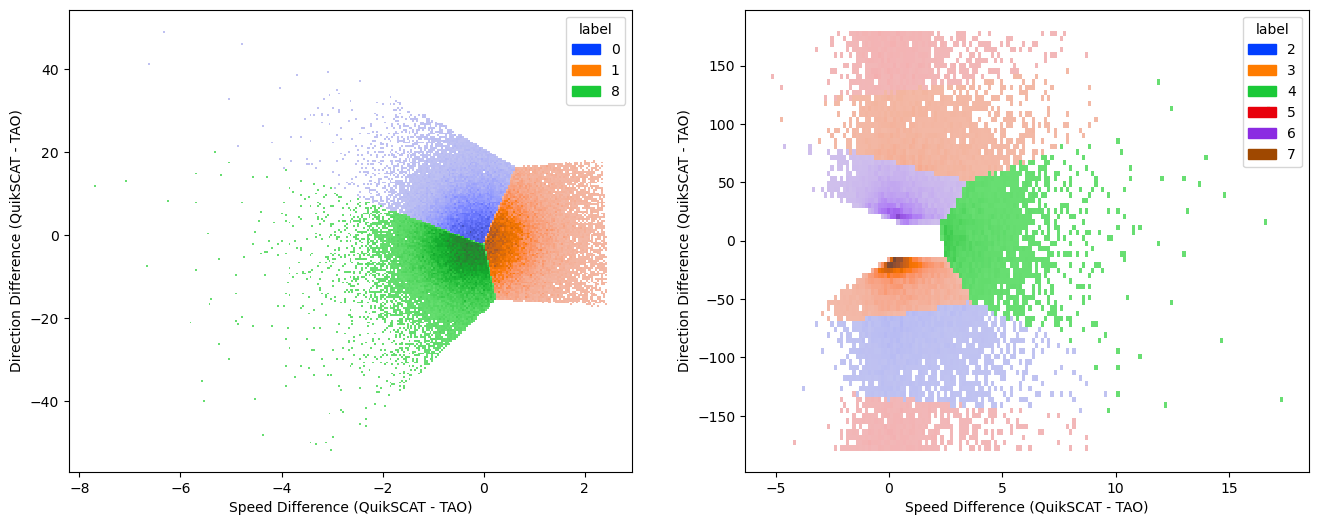

In [15]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]

subDF = df.loc[df['label'].isin([0,1,8])]
s = sns.histplot(subDF, x=xlabel, y = ylabel,
                hue='label',  ax = ax, cbar = False,
                palette = sns.color_palette("bright"))

ax = axes[1]

subDF = df.loc[df['label'].isin([2,3,4,5,6,7])]
s = sns.histplot(subDF, x=xlabel, y = ylabel,
                hue='label',  ax = ax, cbar = False,
                palette = sns.color_palette("bright"))


In [16]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([2,3,4,5,6,7])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

148727


In [17]:
def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['Wind Speed (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

def getDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        QSdir = subDF['Wind Direction (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getXSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Zonal Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Ux_10N {timeWindow}min'
        QSspeed_x = subDF['Zonal Wind Speed (QuikSCAT)']
        TAOspeed_x = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_x, TAOspeed_x)[0,1]
        return corr
    else:
        return -999

def getYSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
        if timeWindow == 10:
            TAOlabel = 'Meridional Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Vy_10N {timeWindow}min'
    if isPresent:
        QSspeed_y = subDF['Meridional Wind Speed (QuikSCAT)']
        TAOspeed_y = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_y, TAOspeed_y)[0,1]
        return corr
    else:
        return -999



    

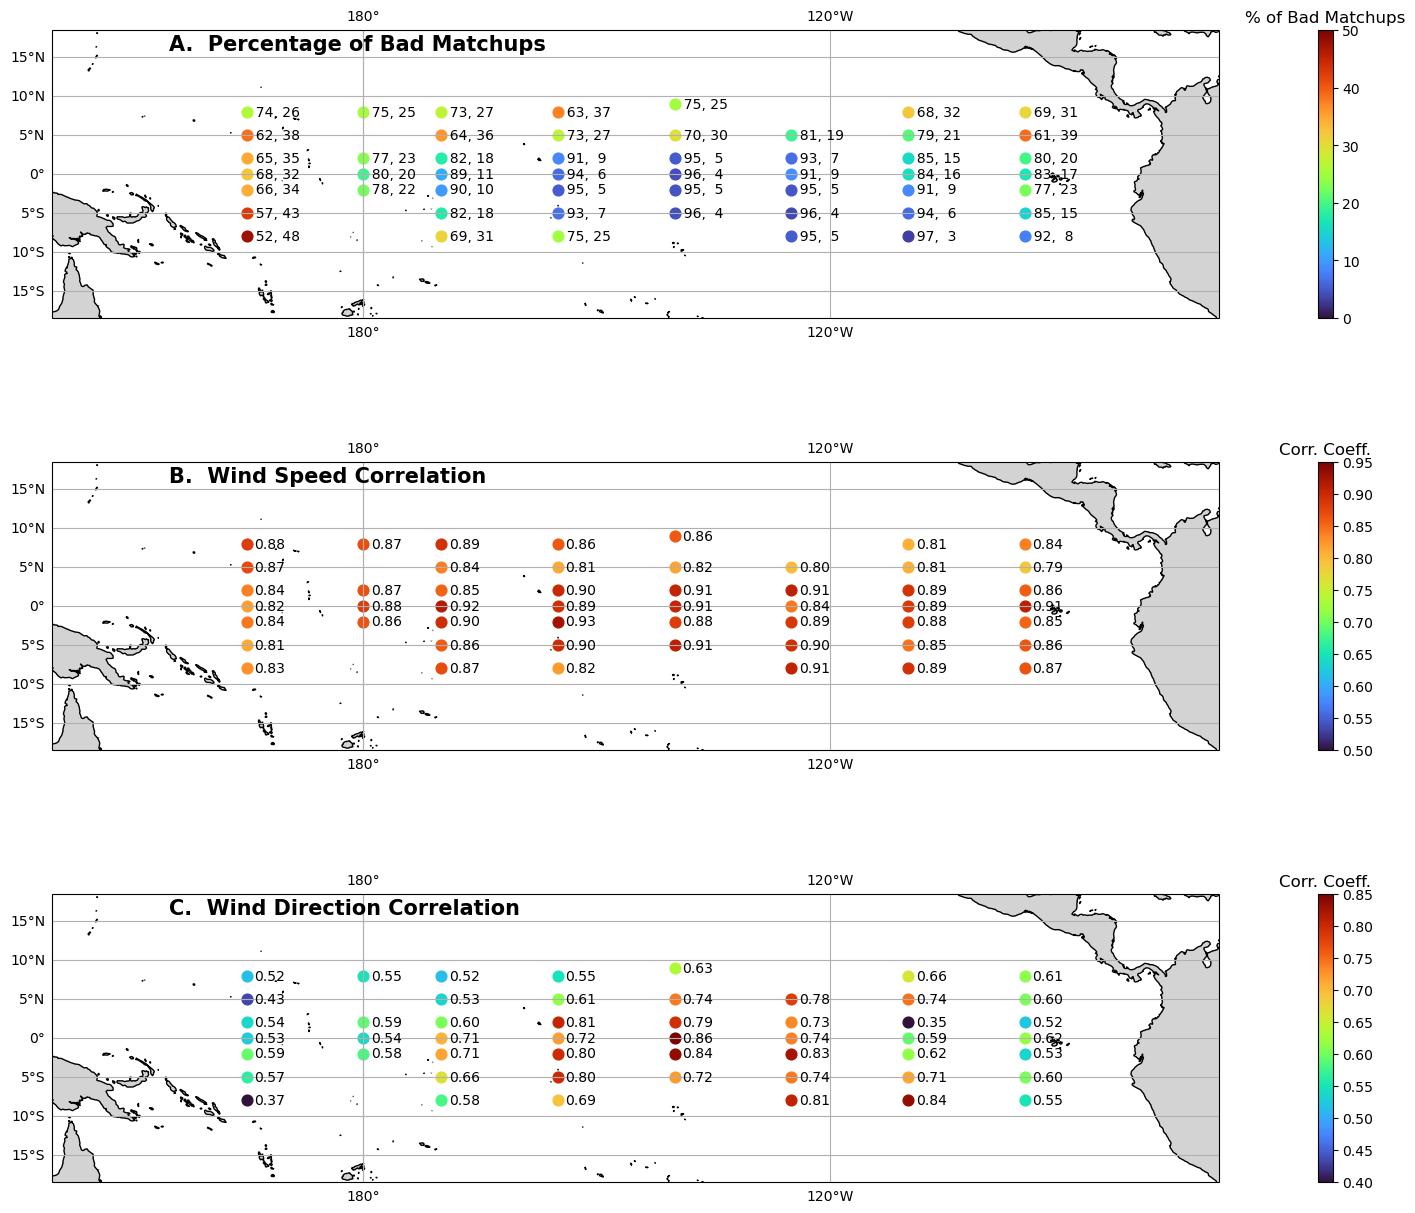

In [18]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=50, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

###################################################################################################################
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.5, vmax=0.95, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


###################################################################################################################
ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, df)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.40, vmax=0.85, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='Wind Direction (TAO)', ylabel='Wind Direction (QuikSCAT)'>

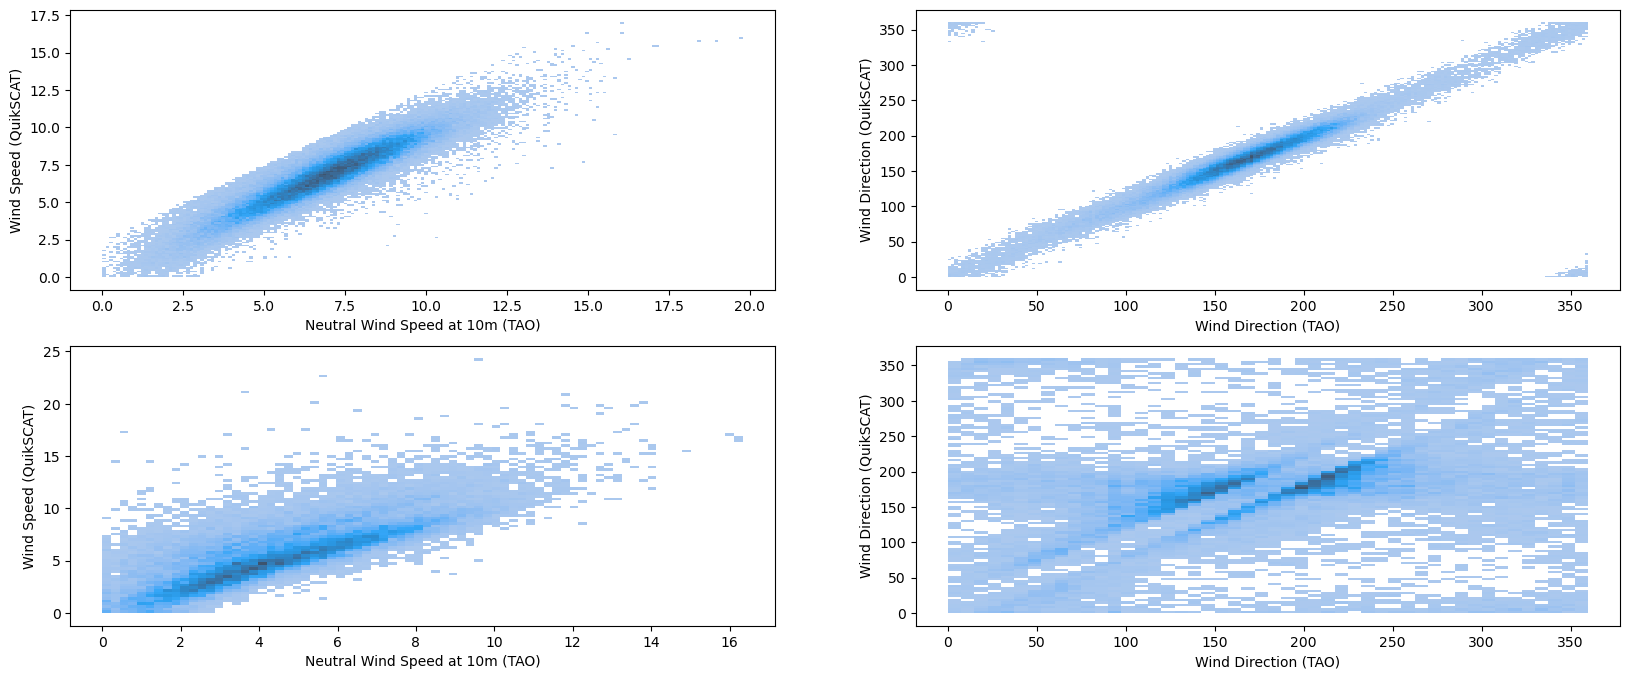

In [19]:
fig, axes = plt.subplots(nrows=2 , ncols=2, figsize=(20,8))

subDF = df.loc[df['GoodBad'] == 'good']
ax = axes[0,0]
xlabel = 'Neutral Wind Speed at 10m (TAO)'
ylabel = 'Wind Speed (QuikSCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


ax = axes[0,1]
xlabel = 'Wind Direction (TAO)'
ylabel = 'Wind Direction (QuikSCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


subDF = df.loc[df['GoodBad'] == 'bad']
ax = axes[1,0]
xlabel = 'Neutral Wind Speed at 10m (TAO)'
ylabel = 'Wind Speed (QuikSCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


ax = axes[1,1]
xlabel = 'Wind Direction (TAO)'
ylabel = 'Wind Direction (QuikSCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='Meridional Neutral Wind Speed (TAO)', ylabel='Meridional Wind Speed (QuikSCAT)'>

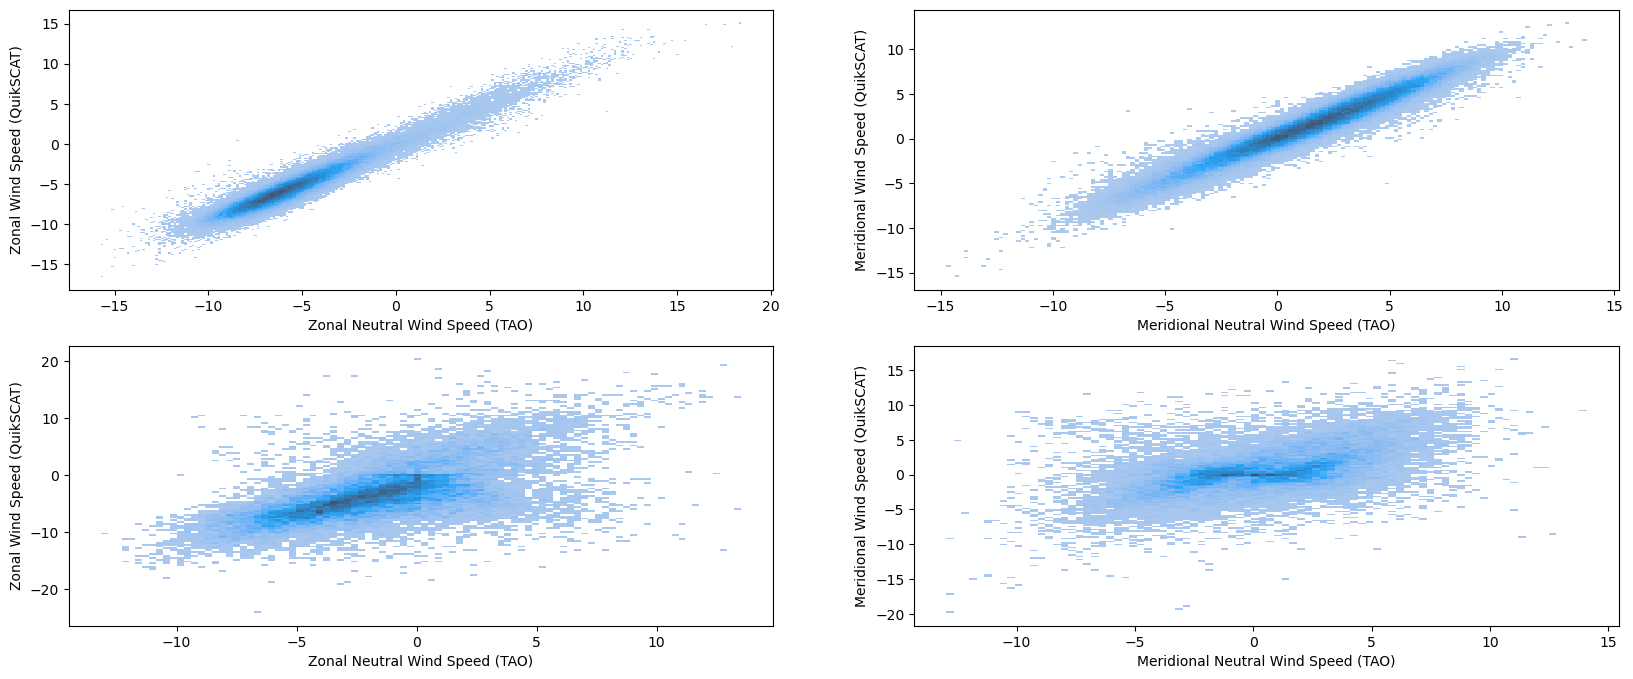

In [20]:
fig, axes = plt.subplots(nrows=2 , ncols=2, figsize=(20,8))

subDF = df.loc[df['GoodBad'] == 'good']
ax = axes[0,0]
xlabel = 'Zonal Neutral Wind Speed (TAO)'
ylabel = 'Zonal Wind Speed (QuikSCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


ax = axes[0,1]
xlabel = 'Meridional Neutral Wind Speed (TAO)'
ylabel = 'Meridional Wind Speed (QuikSCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


subDF = df.loc[df['GoodBad'] == 'bad']
ax = axes[1,0]
xlabel = 'Zonal Neutral Wind Speed (TAO)'
ylabel = 'Zonal Wind Speed (QuikSCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


ax = axes[1,1]
xlabel = 'Meridional Neutral Wind Speed (TAO)'
ylabel = 'Meridional Wind Speed (QuikSCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


Text(0.1, 0.95, 'D.  Wind Direction Correlation for Bad Matchups')

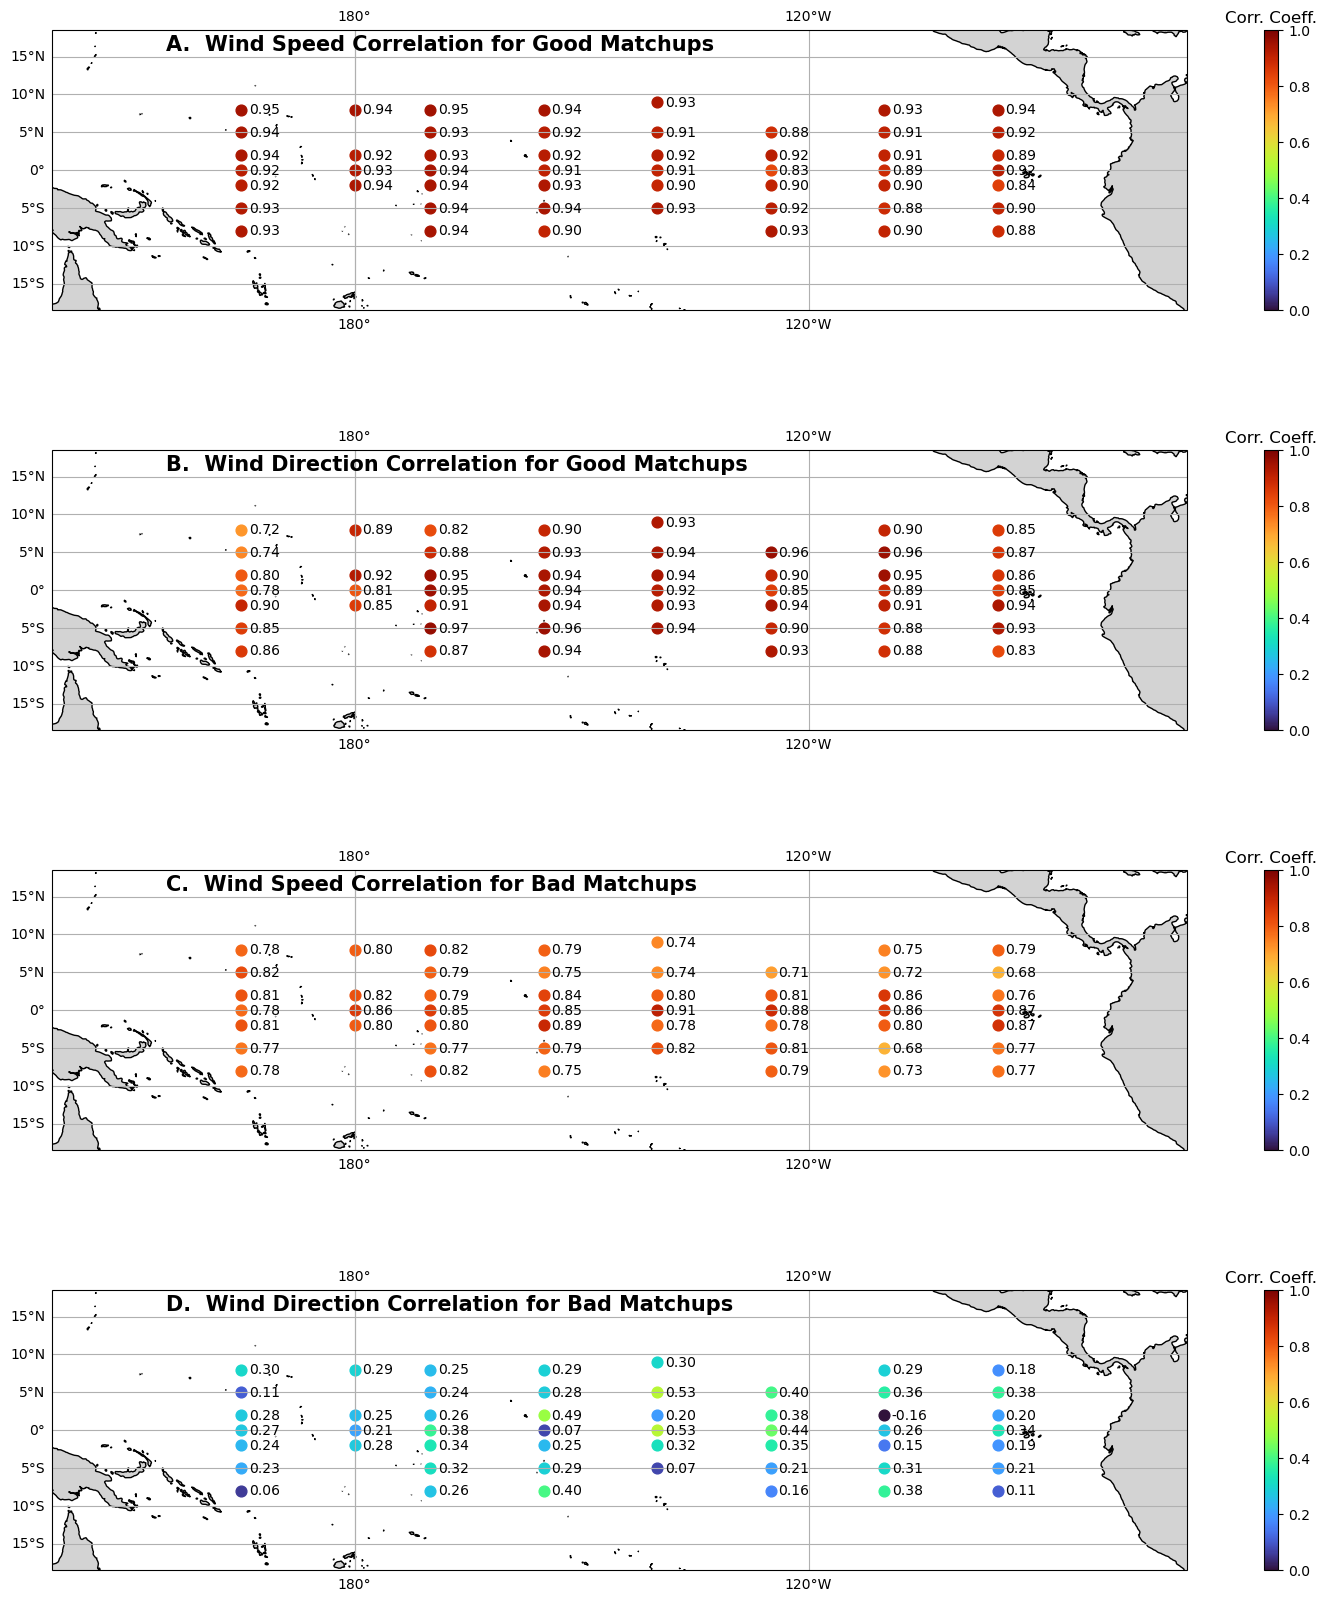

In [21]:
fig, axes = plt.subplots(nrows = 4, 
                       ncols = 1, 
                        figsize = (20,20),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


subDF = df.loc[df['GoodBad'] =='good']
ax = axes[0] 
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'A.  Wind Speed Correlation for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)



###################################################################################################################

ax = axes[1]
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Direction Correlation for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

###################################################################################################################
subDF = df.loc[df['GoodBad'] =='bad']
ax = axes[2] 
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'C.  Wind Speed Correlation for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)



###################################################################################################################
ax = axes[3]
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'D.  Wind Direction Correlation for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

###################################################################################################################

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

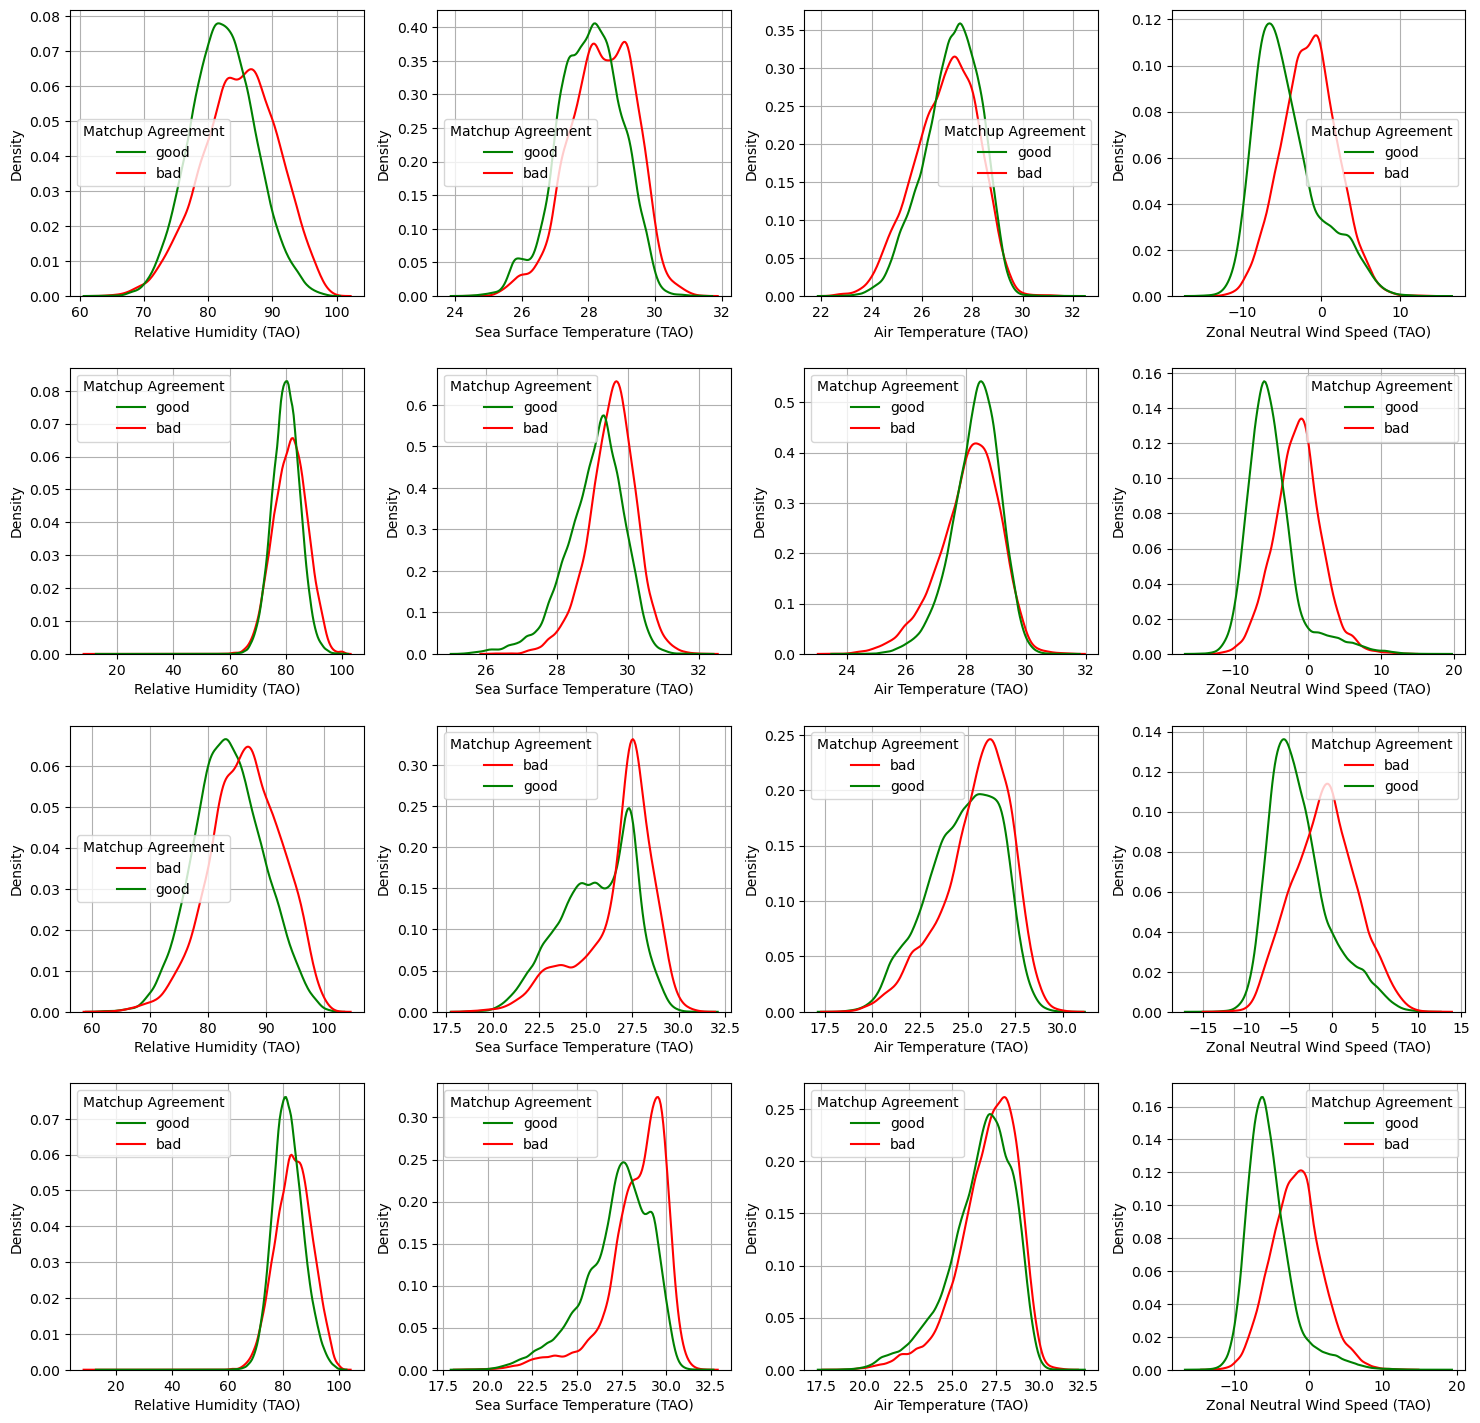

In [22]:
fig, axes = plt.subplots(nrows=4, ncols =4, sharex = False, figsize=(15,16))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(65,100,50)
custom_bins_SST = np.linspace(20,32,50)
custom_bins_AIRT = np.linspace(15,32,50)
custom_bins_U10x = np.linspace(-15,10,50)
ny = 10
stack_order = {'good', 'bad'}

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[0,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(25,31,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')


ax = axes[0,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(23,30,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[0,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[1,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[1,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[1,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon > -120 E '

ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')
#ax.text(-0.01, 0.33, 'Eastern Pacific', transform=ax.transAxes, rotation=90)

ax = axes[2,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(20,30,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[2,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(20,29,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[2,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[3,0]
subDF = df.copy()
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[3,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[3,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[3,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.25, hspace=0.25)
#plt.savefig('StackedHistogram.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecat

Text(0, 0.5, 'Bad Data %')

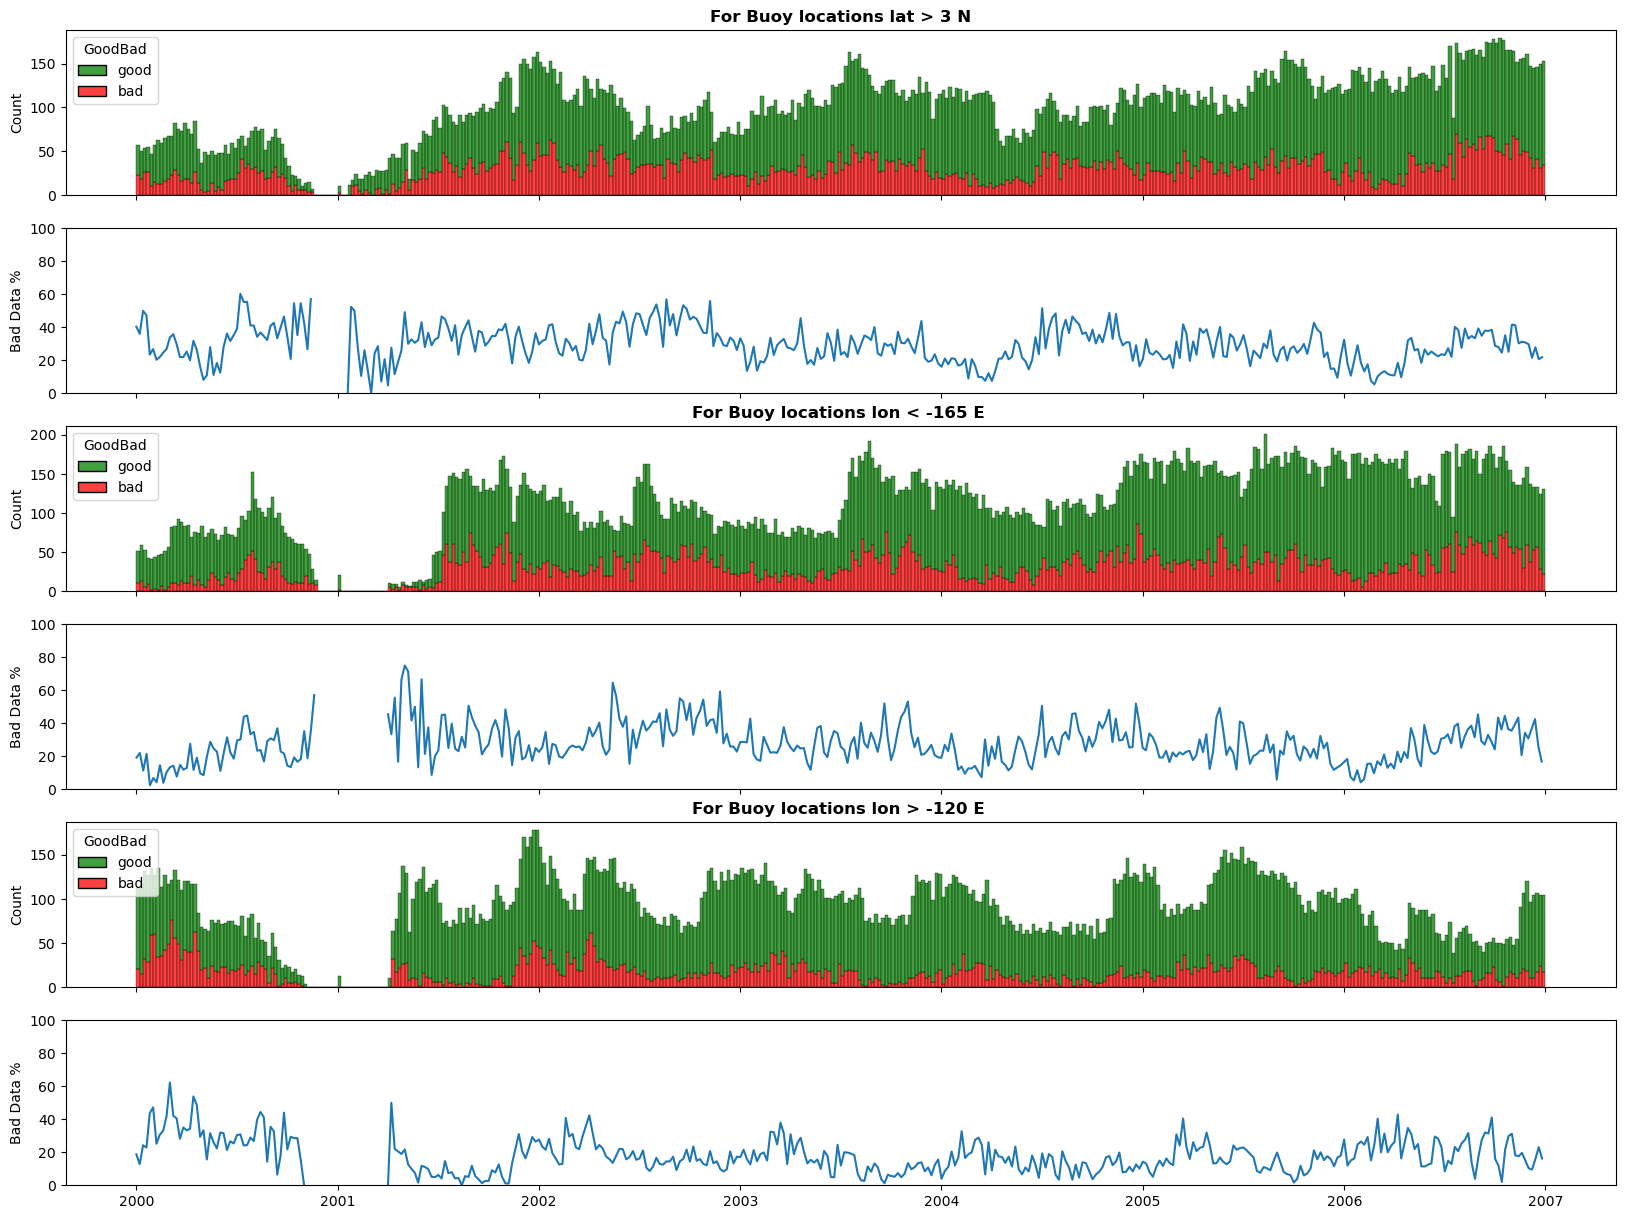

In [23]:
fig, axes = plt.subplots(nrows=6, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
nx = 12*7*5 # 168
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='QS_TIME', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['QS_TIME'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['QS_TIME'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='QS_TIME', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['QS_TIME'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['QS_TIME'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='QS_TIME', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['QS_TIME'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['QS_TIME'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

In [24]:
df['day'] = np.array([var.timetuple().tm_yday for var in df['QS_TIME']])

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecat

Text(0.5, 0, 'Day of year')

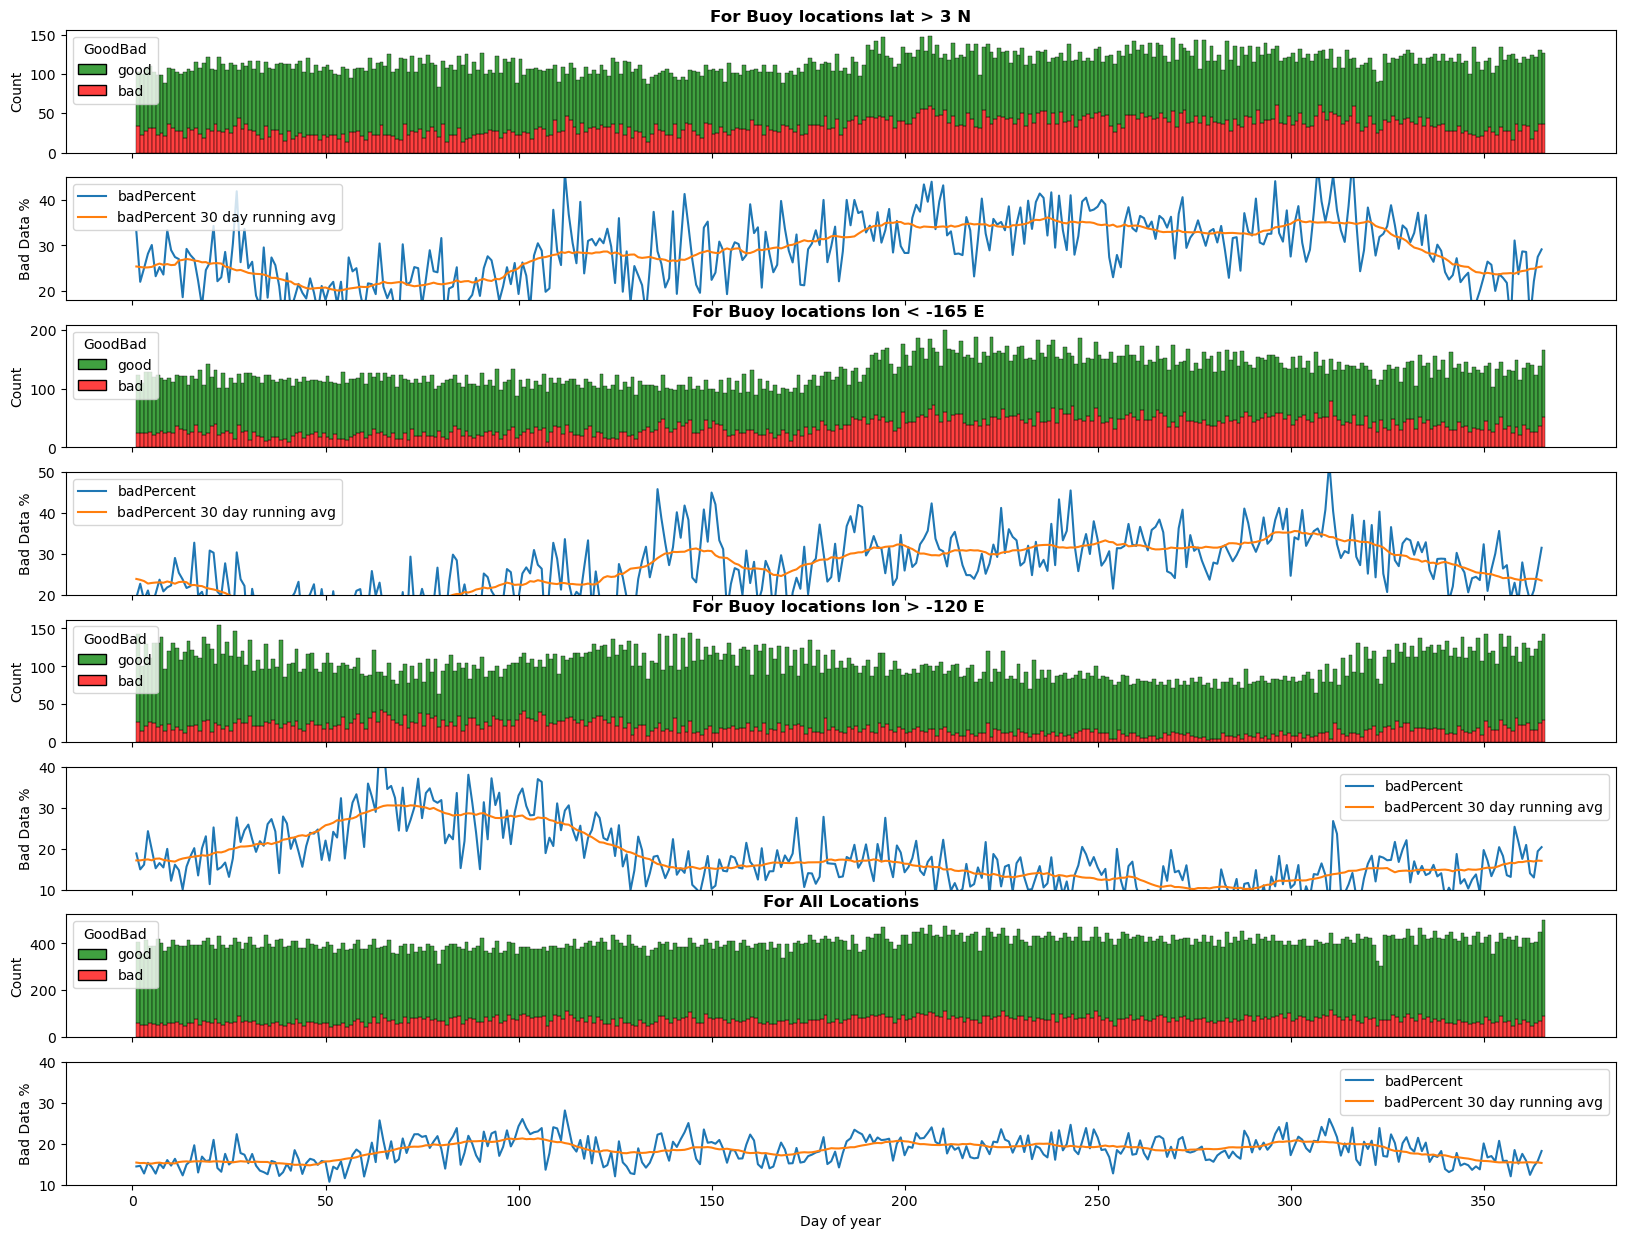

In [25]:
fig, axes = plt.subplots(nrows=8, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
nx = 365 #int(365//3)
ny = 10
nrun = 30

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent, label ='badPercent')
ax.plot(bin_edges[0:-1], convolve1d(BadPercent, np.ones(nrun)/nrun, mode='wrap'), label =f'badPercent {nrun} day running avg')
ax.legend()
ax.set_ylim(18,45)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent, label ='badPercent')
ax.plot(bin_edges[0:-1], convolve1d(BadPercent, np.ones(nrun)/nrun, mode='wrap'), label =f'badPercent {nrun} day running avg')
ax.legend()
ax.set_ylim(20,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent, label ='badPercent')
ax.plot(bin_edges[0:-1], convolve1d(BadPercent, np.ones(nrun)/nrun, mode='wrap'), label =f'badPercent {nrun} day running avg')
ax.set_ylim(10,40)
ax.legend()
ax.set_ylabel('Bad Data %')
################################################################################################
################################################################################################

title = 'For All Locations'
ax = axes[6]
subDF = df.copy()
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[7]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent, label ='badPercent')
ax.plot(bin_edges[0:-1], convolve1d(BadPercent, np.ones(nrun)/nrun, mode='wrap'), label =f'badPercent {nrun} day running avg')
ax.set_ylim(10,40)
ax.legend()
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Day of year')
ax.set_xlabel('Day of year')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecat

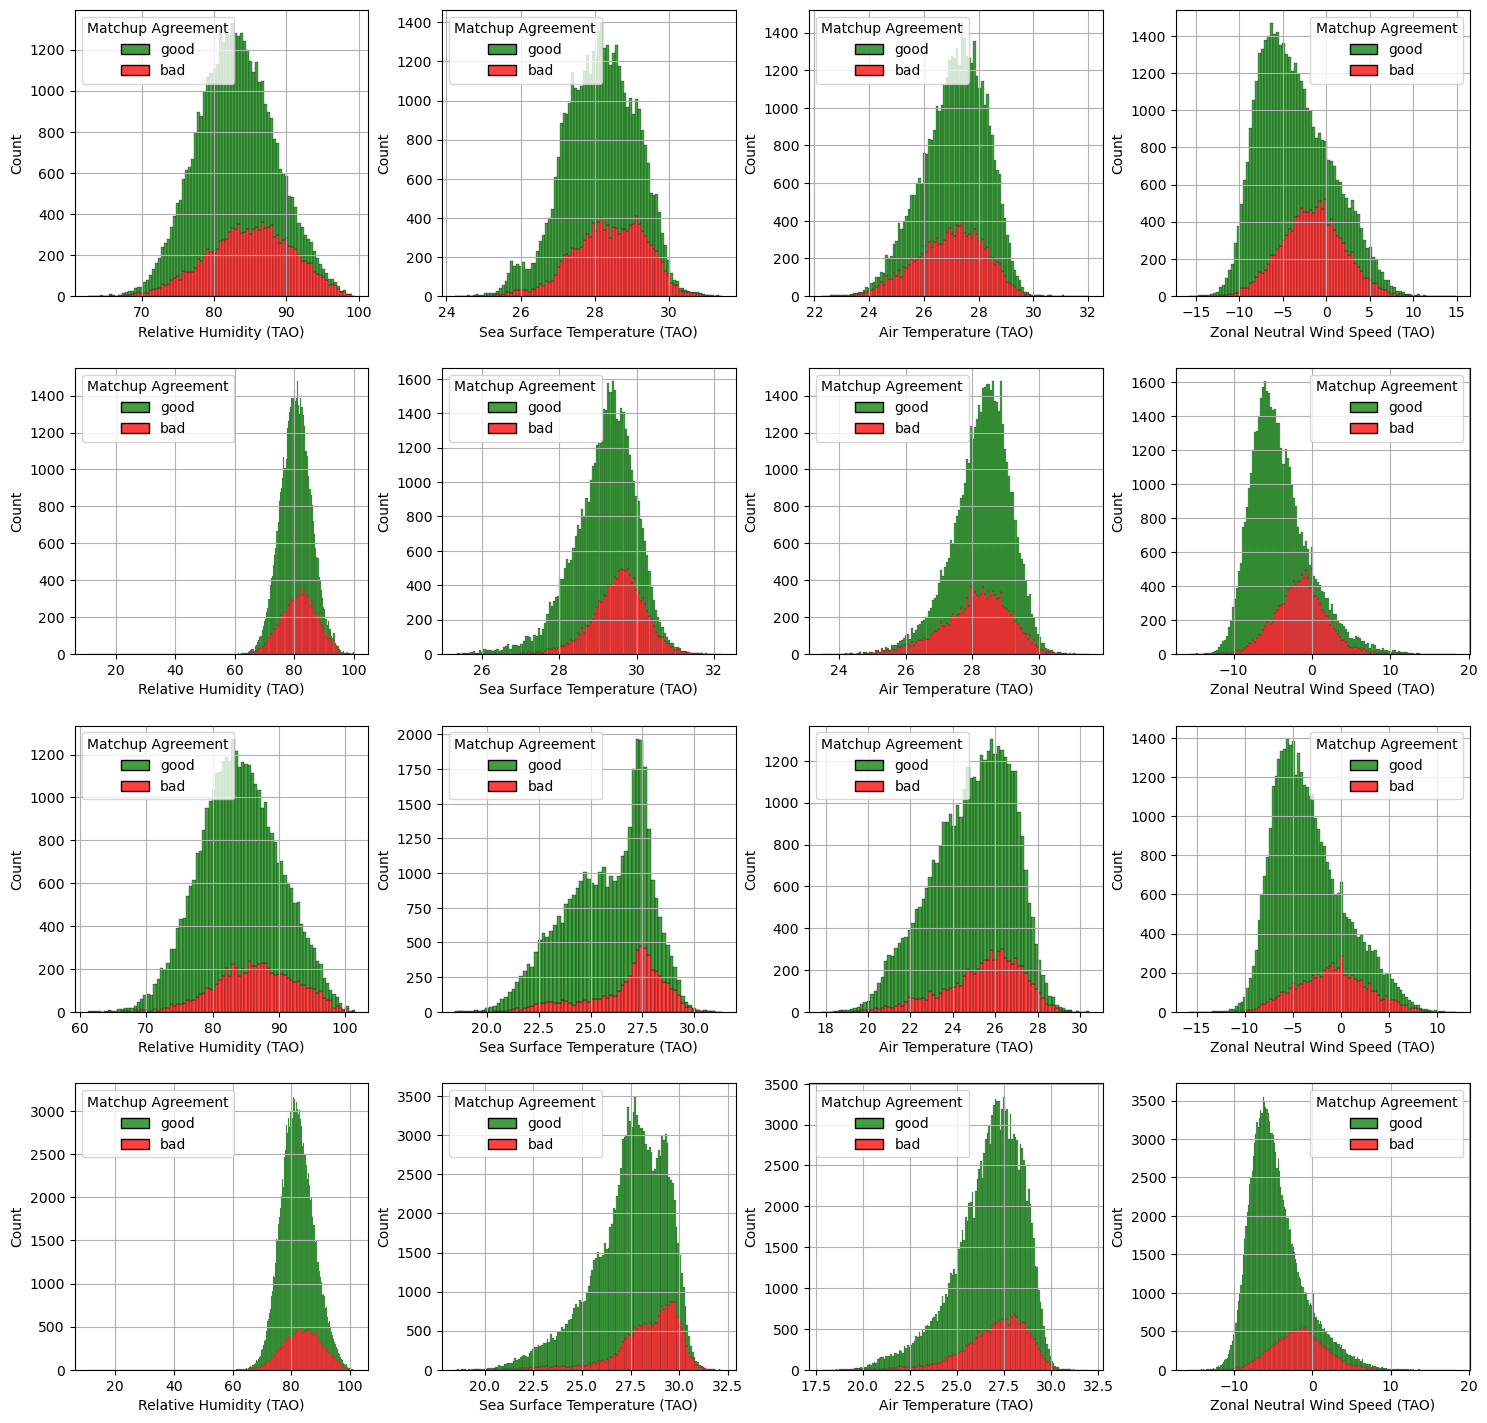

In [26]:
fig, axes = plt.subplots(nrows=4, ncols =4, sharex = False, figsize=(15,16))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(65,100,50)
custom_bins_SST = np.linspace(20,32,50)
custom_bins_AIRT = np.linspace(15,32,50)
custom_bins_U10x = np.linspace(-15,10,50)
ny = 10
stack_order = ['good', 'bad']

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, 
             hue='Matchup Agreement', 
             multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)

#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[0,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(25,31,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')


ax = axes[0,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(23,30,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[0,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[1,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[1,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[1,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon > -120 E '

ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')
#ax.text(-0.01, 0.33, 'Eastern Pacific', transform=ax.transAxes, rotation=90)

ax = axes[2,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(20,30,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[2,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(20,29,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[2,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[3,0]
subDF = df.copy()
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[3,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[3,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[3,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.25, hspace=0.25)
#plt.savefig('StackedHistogram.png', dpi = 100)